# Explotation of lipidomics data

The aim of this exercise is to visually divide samples by exposure. The main task here is to  find discriminating features. This is what machine learning is about. 

In [1]:
# First we load some libraries that we always need
# If you do not know what they are good for I suggest 
# three options:
# 1. Do not worry about this for now
# 2. Use google to find information
# 3. Ask somebody who might know
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

First we locate the data files we are going to work with. This is a first major obstacle. If we need only one file it is easy, but for different reasons the data we wish to analyze can be spread around several files. This is the case here, so we need to do some work already at this stage. Unfortunately, this happens more often than not.

In [2]:
filename = '../rawdata/lipidomics/LiverData.xlsx'
df = pd.read_excel(filename)
df.set_index('Fish ID', inplace=True)

To get an idea about the data we look at the first few rows

In [3]:
df.head()

com1          com2          com3  \
Fish ID                                                                        
20180217_Mse_POS_iv 2 Liver_173916  30078.778970  24842.548308  22330.104640   
20180217_Mse_POS_iv 2 Liver_173936  34152.332713  24074.616508  18139.581690   
20180217_Mse_POS_iv 2 Liver_173986  39071.253106  26172.215465  20989.814462   
20180217_Mse_POS_iv 2 Liver_173996  30438.986082  25673.009153  24054.280242   
20180217_Mse_POS_iv 2 Liver_174116  30716.788122  22597.943060  18216.010252   

                                            com4         com5         com6  \
Fish ID                                                                      
20180217_Mse_POS_iv 2 Liver_173916  14831.694869  5134.393008  4279.330924   
20180217_Mse_POS_iv 2 Liver_173936  15909.796172  6083.857767  5128.421550   
20180217_Mse_POS_iv 2 Liver_173986  18776.712697  6456.031668  8060.214950   
20180217_Mse_POS_iv 2 Liver_173996  14454.713377  3973.723238  3624.650282   
20180217_Mse_POS_iv 2 Liver_174116  14575.899364  5758.935661  4664.850430   

                                           com7         com8         com9  \
Fish ID                                                                     
20180217_Mse_POS_iv 2 Liver_173916  3934.937143  4362.935110  4311.907459   
20180217_Mse_POS_iv 2 Liver_173936  5178.110579  5228.091309  4573.025693   
20180217_Mse_POS_iv 2 Liver_173986  5805.756221  5201.906572  5579.196557   
20180217_Mse_POS_iv 2 Liver_173996  4027.527158  5308.061179  3583.175379   
20180217_Mse_POS_iv 2 Liver_174116  4888.974991  3782.921511  4488.545983   

                                          com10  ...       com437      com438  \
Fish ID                                          ...                            
20180217_Mse_POS_iv 2 Liver_173916  4495.494577  ...  4449.967904  865.416496   
20180217_Mse_POS_iv 2 Liver_173936  3305.225939  ...  4043.404311  590.505658   
20180217_Mse_POS_iv 2 Liver_173986  3661.485074  ...  4143.951589  893.447341   
20180217_Mse_POS_iv 2 Liver_173996  4635.257488  ...  3937.192687  593.917463   
20180217_Mse_POS_iv 2 Liver_174116  3916.561069  ...  4115.130753  470.945983   

                                    Tank  Number  Weight  Length  LiverWeight  \
Fish ID                                                                         
20180217_Mse_POS_iv 2 Liver_173916     1       1     174    27.0         11.9   
20180217_Mse_POS_iv 2 Liver_173936     1       2     179    26.5         11.5   
20180217_Mse_POS_iv 2 Liver_173986     1       3     184    27.6         12.8   
20180217_Mse_POS_iv 2 Liver_173996     1       4     176    26.9         11.6   
20180217_Mse_POS_iv 2 Liver_174116     2       5     189    28.0         10.2   

                                    LiverSomaticIndex  Experiment  Dose  
Fish ID                                                                  
20180217_Mse_POS_iv 2 Liver_173916           6.839080          WY  High  
20180217_Mse_POS_iv 2 Liver_173936           6.424581          WY  High  
20180217_Mse_POS_iv 2 Liver_173986           6.956522          WY  High  
20180217_Mse_POS_iv 2 Liver_173996           6.590909          WY  High  
20180217_Mse_POS_iv 2 Liver_174116           5.396825   Control 1    c1  

[5 rows x 446 columns]

Extract data columns.

In [4]:
com_cols = [col for col in df.columns if 'com' in col]
metadata_cols = [col for col in df.columns if 'com' not in col]

In [5]:
print(metadata_cols)

['Tank', 'Number', 'Weight', 'Length', 'LiverWeight', 'LiverSomaticIndex', 'Experiment', 'Dose']


In [6]:
df[com_cols] = np.arcsinh(df[com_cols].astype(float) / 5)

In [7]:
# Construct auxillary dataframes holding the flipped and averaged expressions
#df2['doses'] = df_meta['Experiment']
dfgroups = df.groupby(df['Experiment'])
# Extract the averaged expressions in a numpy array
fit_values = dfgroups[com_cols].mean().values
# Clean up by deleting the auxillary dataframes

del dfgroups

### Magic data manipulation. 

We first compute the first 5 principal directions of the gene ids with respect to the samples grouped into dosage. Then we use these principal directions to project the individual samples to 5 dimensional space. We store the result in the variable `X`.

In [8]:
# Import PCA module
from sklearn.decomposition import PCA
# Fit and transform PCA
pca = PCA(n_components=5).fit(fit_values)
print('explained_variance_ratio', np.cumsum(pca.explained_variance_ratio_))
X = pca.transform(df[com_cols].values)

explained_variance_ratio [0.63785771 0.85571681 0.95752838 1.         1.        ]


### Visualization


We define a helper function for plotting. It takes several inputs.
* X is two-dimensional data that will be plotted by placing abbreviated dose names in the appropritat position on the plane
* y_text holds the dose abbreviations
* y_color specifies the colors. To begin with we want text and color to correspond.

In [9]:
from itertools import cycle, islice
def plot_embedding(X, y_text, y_color=None, title=None, colors=None):
    if y_color is None:
        y_color = y_text
    if colors is None:
        palette = np.vstack((plt.cm.tab10(np.arange(10)), plt.cm.Set3(np.arange(12))))
        palette = np.array(list(islice(cycle(palette), len(np.unique(y_color)))))
        colors = {}
        for idx, value in enumerate(np.unique(y_color)):
            colors[value] = palette[idx]
    x_min, x_max = np.min(X, axis=0), np.max(X, axis=0)
    dimensions = x_max - x_min
    x_max = x_max + 0.1*dimensions
    x_min = x_min - 0.05*dimensions

    #plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y_text[i]),
                 color=colors[y_color[i]],
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xlim([x_min[0], x_max[0]])
    plt.ylim([x_min[1], x_max[1]])
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

We make a list of dosage abbreviations

In [11]:
doses = df['Experiment'].values
y_dose = np.empty(len(doses), dtype=int)
for idx, dose in enumerate(np.unique(doses)):
    y_dose[np.array(doses) == dose] = idx

Compute UMAP embedding intended to visualize the data

### Plot the data

We plot the first two principal components

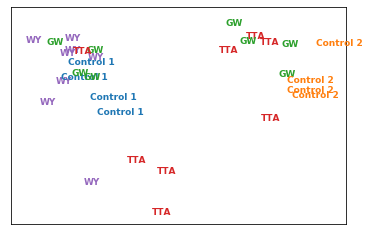

In [12]:
plot_embedding(X[:, :2], 
               doses, 
               y_color=y_dose, colors=None)

Next we compute a fancy embedding of the all principal components.

In [13]:
# Import UMAP module
from umap import UMAP
# Suppress annoying warnings
import warnings
warnings.filterwarnings('ignore')
Y = UMAP(n_components=2).fit_transform(X)

And plot it

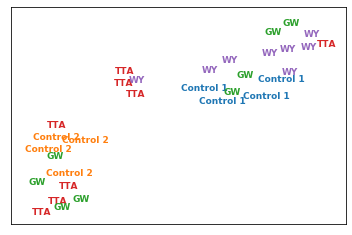

In [14]:
plot_embedding(Y, 
               doses, 
               y_color=y_dose, colors=None)

### Data interpretation

What is going on here? Can you come up with some hypotheses about the experiment that can explain this plot?

Can you find some components that explain why we obtain two or three groups?